# Временные ряды 3. 

# Моделируем временные ряды по ARIMA

Стационарные и нестационарные модели временных рядов требуют отдельного анализа. Отделить стационарную часть от нестационарной можно за счет правильного выбора параметров сглаживания и представления модели в виде суммы (или иногда произведения) стационарных и нестационарных частей ряда. Вопрос дня - как определить параметры сглаживания и как предсказывать стационарную часть ряда.

Пока наш алгоритм обработки ряда преодолел 2 основных этапа:
- визуализация и зачистка от проблем
- анализ характера ряда как стационарного или нестационарного

Попробуем понять, что нужно делать, что бы построить наконец модель во времени с учетом всего вместе. Вернемся к нашим рядам: "Потребление энергии" и "Цена нефти BRENT". Будем использовать предобработанные версии этих рядов с признаками из календаря.   




## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

C:\Users\1\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


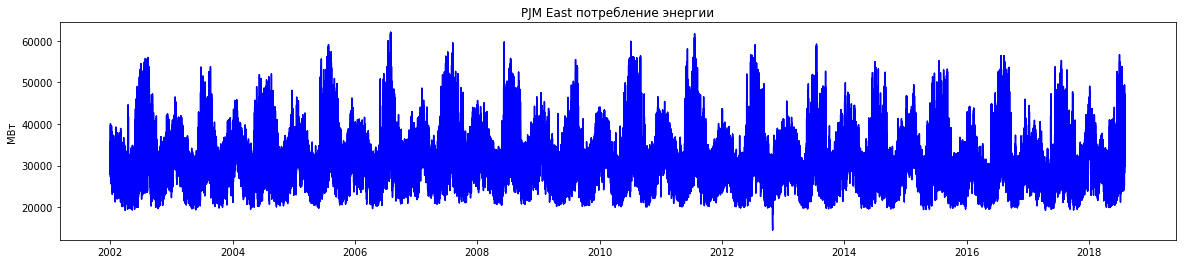

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [5]:


path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Основные статистики ряда остались без изменений.

In [6]:
brent_data.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,2667.000000,2667.000000,2667.00000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,81.533547,2014.661042,6.51706,15.715786,2.505062,182.901762,26.486689,2.537308,0.027747,0.026997,0.029621
std,26.349469,2.663525,3.43026,8.780275,1.112684,104.741067,14.935147,1.894937,0.164277,0.162104,0.169572
min,27.850000,2010.000000,1.00000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,56.840000,2012.000000,4.00000,8.000000,2.000000,92.000000,14.000000,1.000000,0.000000,0.000000,0.000000
50%,77.710000,2015.000000,7.00000,16.000000,3.000000,183.000000,27.000000,2.000000,0.000000,0.000000,0.000000
75%,108.190000,2017.000000,9.00000,23.000000,3.000000,273.000000,39.000000,4.000000,0.000000,0.000000,0.000000
max,126.900000,2019.000000,12.00000,31.000000,4.000000,366.000000,53.000000,6.000000,1.000000,1.000000,1.000000


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

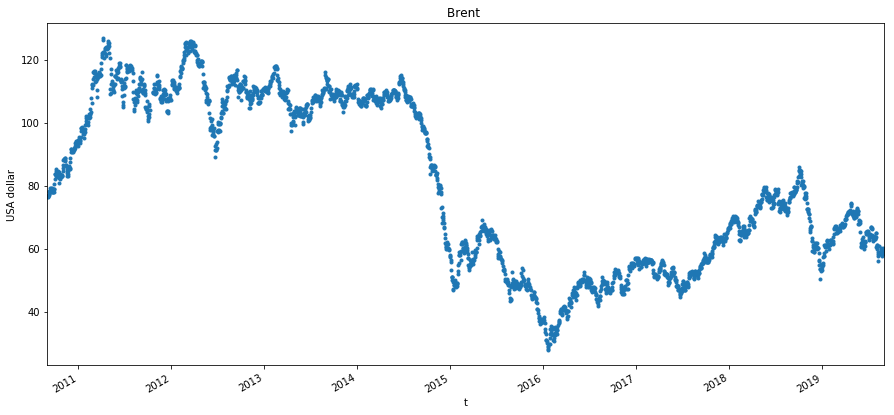

In [7]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Сравним два примера "Почасовое потребление энергии" и "подневные цены на нефть":


Характер этих рядов существенно отличается. Энергия имеет выраженный порядок смены сезонов (рис.1) и дня и ночи (рис.2). Тогда как цена нефти не показывает никакой подобной динамики (Рис.3). Связать цены на нефть с календарем на этом этапе анализа не удалось. Это видно, по не очень впечатляющим результатам моделирования цены нефти (Временные ряды. часть 1 и 2).

В обеих последовательностях есть необычные артефакты: выброс 2012.10 в потреблении энергии и провал цены на нефть в 2014(природу которого нужно изучать).

Попробуем определить параметры модели для этих примеров.

### Методы анализа рядов

При построении моделей временных обычно говорят о следующих типах моделей:
- статистические, где зависимость будущего значения от прошлого задается в виде некоторого уравнения, а их делят на регрессионные модели (линейная регрессия, нелинейная регрессия), авторегрессионные модели (ARIMAX), модель экспоненциального сглаживания и т.д. Эта форма описания ряда содержит представление о формуле с параметрами, которые хорошо обходят точки соответствующие прошлому и, наверное, будут хорошо описывать будущее. 
- структурные модели, где зависимость будущего значения от прошлого задается в виде некоторой структуры и правил перехода по ней. К ним относят нейросетевые модели, модели на базе цепей Маркова, модели на базе классификационно-регрессионных деревьев и т.д.
- спектральные модели, которые основаны на определении временного ряда как совокупности простых процессов разной частоты.

Таким образом, возвращаясь к объектам реального мира для статистических моделей, если наш кот бегает за игрушкой и нам известна масса и размер котенка, а так же на основании предшествующих измерений нам удалось оценить корреляцию возраста, размера и массы котенка с его скоростью и маневренностью, то мы сможем предсказать, как быстро будет бегать питомец в будущем.  
С другой стороны модели на основе методов обучения, предполагают, что связь доступных для измерения свойств объекта или предшествующих значений ряда можно получить, если взять достаточно сложную функцию с параметрами и адаптировать(обучить) эти параметры опираясь на известные примеры. Близкие идеи реализует и спектральная модель описания явлений, т.к. ее задача состоит в подборе(вычислении) амплитуд простых процессов, из которых будем складывать описание прошлого.

Все подходы к моделированию рядов объединяет предположение, что будущее в некоторой степени зависит (и повторяет) прошлое. 

Перейдем к рассмотрению способов описания рядов на формальном уровне. По форме можно выделить две основных модели :
- аддитивная :  y(y) = X_trend(t) + X_cicle(t) + e(t)
- мультипликативная :  y(y) = X_trend(t) X_cicle(t) e(t)

Здесь y(y) - изменение значений ряда по времени, X_trend(t) - трендовая составляющая, X_cicle(t) - циклическая с оставляющая и случайная част e(t) ряда.
Разница между ними состоит в способе учета факторов влияющих на общее решение.

Рассмотрим вариант решения задачи описания временного ряда в форме модели ARIMA (статистическая форма анализа ряда) на базе пакета statsmodels http://www.statsmodels.org/dev/tsa.html.

In [8]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


ARMA - Авторегрессионная модель скользящего среднего. В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда (для нефти и Потребления энергии мы из примерно определили в процессе ресемплинга на разные интервалы).

ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построена для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонеты MA.


ARIMA импортируется по: 
    from statsmodels.tsa.arima_model import ARIMA

Строим ARIMA модель:
    model = ARIMA(data, order=(1, 1, 1)), где
     order - порядок модели в формате (p,d,q)
     data - собственно ряд в форме numpy массива
Построим модель по нашему объекту model через обращение к методу fit:
    model_fit = model.fit(disp=False)

Посмотрим , что построилось на старых данных:
    y_p = model_fit.predict(len(data), len(data), typ='levels')

или предскажем новые , начиная от последней точки ряда n новых точек :
    y_f =model_fit.forecast(n), где y_f - содержит 3 массива y_f[0] - основное предсказание, y_f[1] - оцекнка ошибки и y_f[2] 2-х мерный массив границ доверительного интервала
    
    Для примера возьмем искусственную модель сигнала в составе : тренд - х*3, цикл 5*np.sin(x/20) и стационарная составляющая 5*random(). Таким образом, есть стационарная и нестационарная части ряда. Посмотрим как его смоделировать в ARIMA.

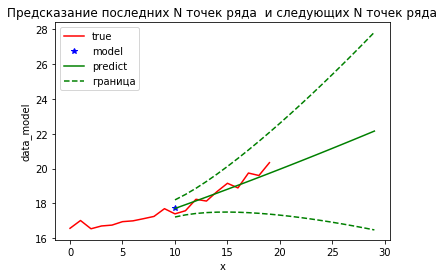

In [50]:
# ARIMA пример
from statsmodels.tsa.arima_model import ARIMA
from random import random
# модельный ряд
np.random.seed(21)
data_model = [x*0.3 +10*np.sin(x/20) + 0.7*np.random.random(1) for x in range(1, 100)]
N=10    # число точек для теста
# строим модель
model = ARIMA(data_model[:-N], order=(1, 1,2))
model_fit = model.fit(disp=False)
# делаем оценку старых значений
y_p = model_fit.predict(len(data_model[:-N]), len(data_model[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_model[-10-N:],'r',label ='true')
plt.plot(10,y_p,'*b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

Сформированная модель устанавливает параметр p=1, d=1 и q=2. Понятно, что получение параметров модели потребовало какого-то анализа поведения ряда. И вообще говоря, модель будет работать для довольно большого диапазона параметров. Наша задача выбрать правильный тип модели сглаживания и определить какие составляющие ряда актуальны именно для нашего случая. Основные варианты описываются двумя моделями ARIMA и SARIMAX. Первый тип моделей не учитывает сезонные циклы, а второй их обработает. Дальнейший анализ позволит включить или отключить составляющие модели (р=0 - нет регрессии средней, q=0 - нет сглаживания, d = 0 - модель без интегральной части). 

Варианты описания задач моделирования временных рядов в statsmodels можно посмотреть в  https://www.machinelearningmastery.ru/time-series-forecasting-methods-in-python-cheat-sheet/ и докементации модуля (ссылка выше)

Итак, необходимо определить значения ARIMA (p, d, q) (текущие) и (P, D, Q) s(сезонные для SARIMAX ) параметры модели, которые оптимизируют точность соответствия модели истинной ситуации. 

Правильная параметризация моделей ARIMA вручную —  процесс довольно кропотливый, требует изучения предметной области и занимает много времени. Посмотрим на инструменты и методы подбора параметров модели ARIMA(SARIMAX). 

**Определим параметры ARIMA**. 

Для этого используем ACF (определит q) и PACF (определит p)

ACF - автокорреляционная функция, по коррелограмме которой можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA. 

PACF - автокорреляционная функция первых разностей, по коррелограмме которой можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR. 

Построим такие коррелограммы из statsmodels по функциям plot_acf() и plot_pacf(). Графики ACF и PACF, где по оси X откладываются номера лагов, а по оси Y значения соответствующих функций.

Для скорости и удобства отображения посмотрим на более простых данных - ресемплингах исходного ряда на дневные(data_d), месячные (data_m), недельные (data_w) и 3-х месячные ряды(data_Y)

In [53]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

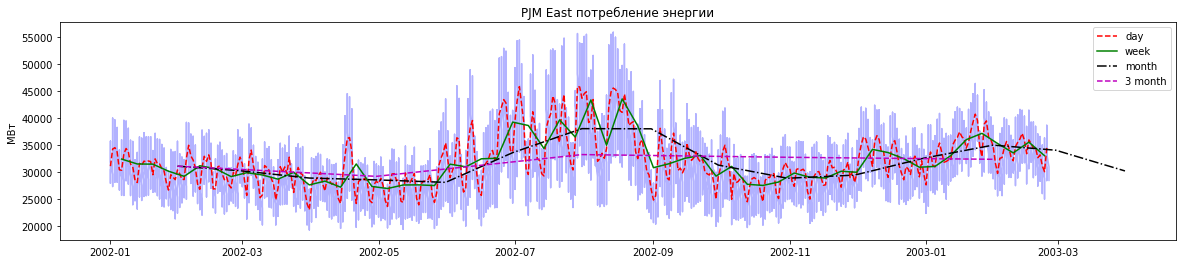

In [11]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Но сначала посмотрим , что можно увидеть для исходной модели (работает очень долго)

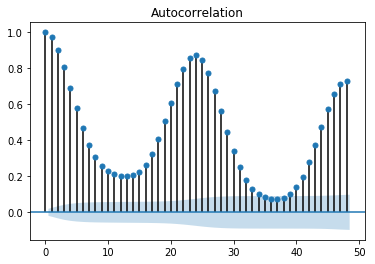

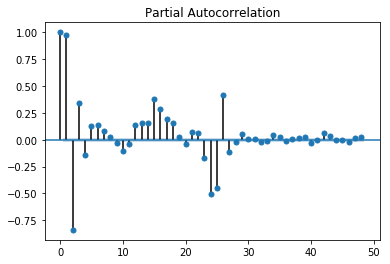

In [18]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()

Получили оценку автокорреляции часовой модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 24 часа(никто и не сомневался см.рис. Autocorrelation) и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 24 часов. Первый график говорит о параметре части MA(24) - т.е следует рассматривать ресемплинг модели (поскольку авторегрессия 24) на дневные модели. По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда. Мы помним, что ADF нам эту нестационарность уже диагностировал (временные ряды 2). Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

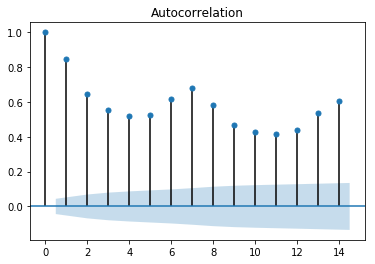

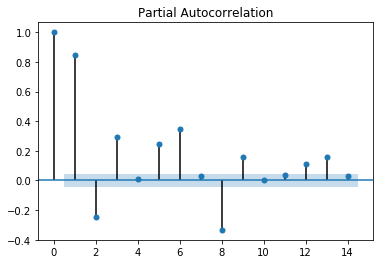

In [16]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values[:2000], lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values[:2000], lags=14)
plt.show()

Картина для дневных примеров имеет более общий вид, но тоже есть значительная автокорреляция по недельным лагам с медленным падением связи в течении 2-х недель(ACF). Практически аналогично выглядит картинка и для разностей(PACF) т.е. есть значительная по 1-му остатку (AR 1) и более слабые связи по неделям (до AR 8 ). Посмотрим как выглядит ряд при ресемплинге на 3-месячных данных.

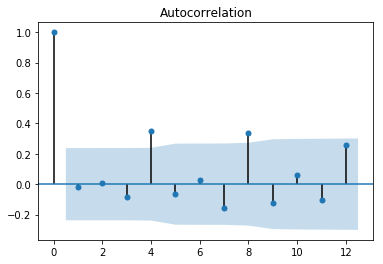

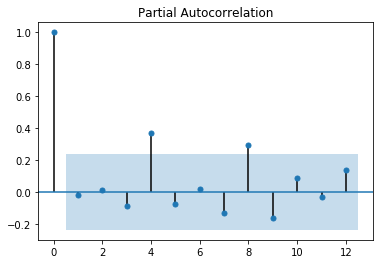

In [19]:
sm.graphics.tsa.plot_acf(data_Y['PJME_MW'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(data_Y['PJME_MW'].values, lags=12)
plt.show()

На трехмесячном графике можно увидеть, что есть ежегодный цикл (лаг 4 и 8) для ACF (МА 4) и PACF (AR 4). Это годовые сезонные изменения по всем периоду наблюдений. Аналогичную картину можно увидеть для оценки автокорреляций на месячных данных:

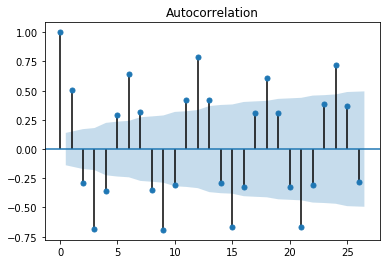

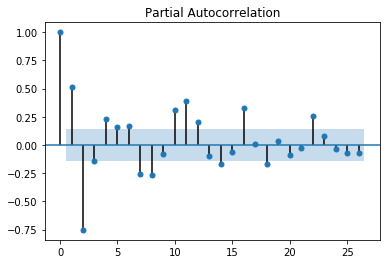

In [20]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

Сохраняется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF) и для разностей важными являются значения внутри первых 3-х значений (PACF). Это позволит определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца. диапазон поиска параметров модели ARIMA для лучшего описания нашего ряда в диапазоне до первых разностей и сглаживаний первого порядка.

Обсудим результаты анализа ACF,PACF. 

Общая рекомендация для оценки параметров:

- p = 1 : ACF - экспоненциально убывает, PACF - имеет резко выделяющееся значение для лага 1, нет корреляций на других лагах.

- p = 2 : ACF имеет форму синусоиды или экспоненциально убывает, PACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах.

- q = 1: ACF имеет резко выделяющееся значение на лаге 1, нет корреляций на других лагах, PACF экспоненциально убывает.

- q = 2: ACF имеет резко выделяющиеся значения на лагах 1, 2, нет корреляций на других лагах, PACF имеет форму синусоиды или экспоненциально убывает.

- p = 1 и q = 1: ACF экспоненциально убывает с лага 1, PACF - экспоненциально убывает с лага 1.

В сезонных рядах ACF и PACF имеют существенные значения на лагах, кратных сезонному лагу.


Рассмотрим результаты моделирования ряда с потенциально хорошими значениями порядками компонент нашего ряда с учетом сезонности в модификации SARIMAX, которая кроме всего прочего строит сезонную составляющую ряда. Фактически строим 3 модели : тренд, модель сезона и модель вокруг сезонных колебаний. А наш ряд очевидно сезонный. В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.

Обозначения для модели включают указание порядка для моделей AR (p), I (d) и MA (q) в качестве параметров функции ARIMA и AR (P), I (D), MA (Q) и m. параметры на сезонном уровне, например SARIMA (p, d, q) (P, D, Q) m, где «m» - количество временных шагов в каждом сезоне (сезонный период). Модель SARIMA может использоваться для разработки моделей AR, MA, ARMA и ARIMA. Принципиально формат обращения остается прежним (как у ARIMA), за исключением добавки сезонных параметров SARIMAX(<данные - массив ряда>,order=[p,d,q], seasonal_order=[ps,ds,qs])

Посмотрим на модель недельного ресемплинга. ACF

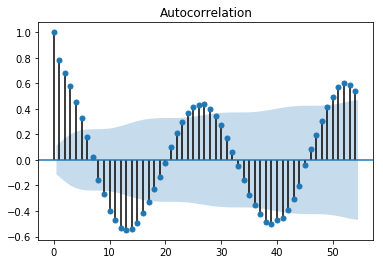

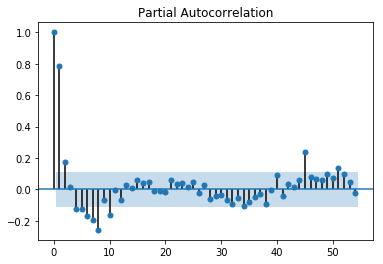

In [22]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values[:300], lags=54)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values[:300], lags=54)
plt.show()

Сезонность - 52 (с некоторым допущением 26) - период в ACF (большой 52 и вложеный 26 ). 
qs - ACF,PACF  - синусоида - пишем в сезоны qs = 1 и возможно 2 (qs = [1,2])
ps - быстро убывает PACF - ps не более 2 (ps =[0,1,2])
ds - предполагаем (ADF (урок 2) - на длине 10 лет - стационарный ряд), что ds=0

p - ACF - синусоида (но это сезон), PACF - на отрезке убывает (хотя тоже видим сезон) и 2 выделенных корреляциит, т.е. p =[0,1, 2]
d - на недельных графиках - по ADF (урок 2 - должен быть стационарным для больших интервалов и нет для маленьких) - d = [0,1,2]

q - не более 6 (по ACF)

Запустим вариант модели:

In [58]:
import warnings

# Определим p, d и q 
q = 2
p = 0
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,52] 


In [59]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [0, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 52]


In [62]:
#для построения модели используем все данные, кроме 12-х последних недель (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[300:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[0, 2, 2]x[0, 0, 1, 52] - AIC:9184.772934403227


In [63]:
print(results.summary().tables[0],results.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  554
Model:             SARIMAX(0, 2, 2)x(0, 0, [1], 52)   Log Likelihood               -4588.386
Date:                              Fri, 31 Jul 2020   AIC                           9184.773
Time:                                      21:29:21   BIC                           9201.607
Sample:                                           0   HQIC                          9191.380
                                              - 554                                         
Covariance Type:                                opg                                         
============================================================================================ ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

Анализ результатов по results:
- коэффициенты при элементах модели имеют большие значения (особенно важны составляющие сглаживания coef: ma.L1, ma.L2 , ma.S.L26)
- можно посмотреть на остатки ряда (results.resid) с точки зрения автокорреляции и убедиться, что они не имеют значительной корреляции (это хорошо, т.к. остатки имеют характер белого шума)

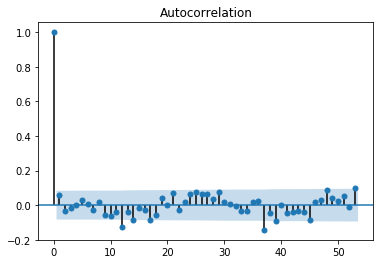

In [64]:
sm.graphics.tsa.plot_acf(results.resid, lags=53)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

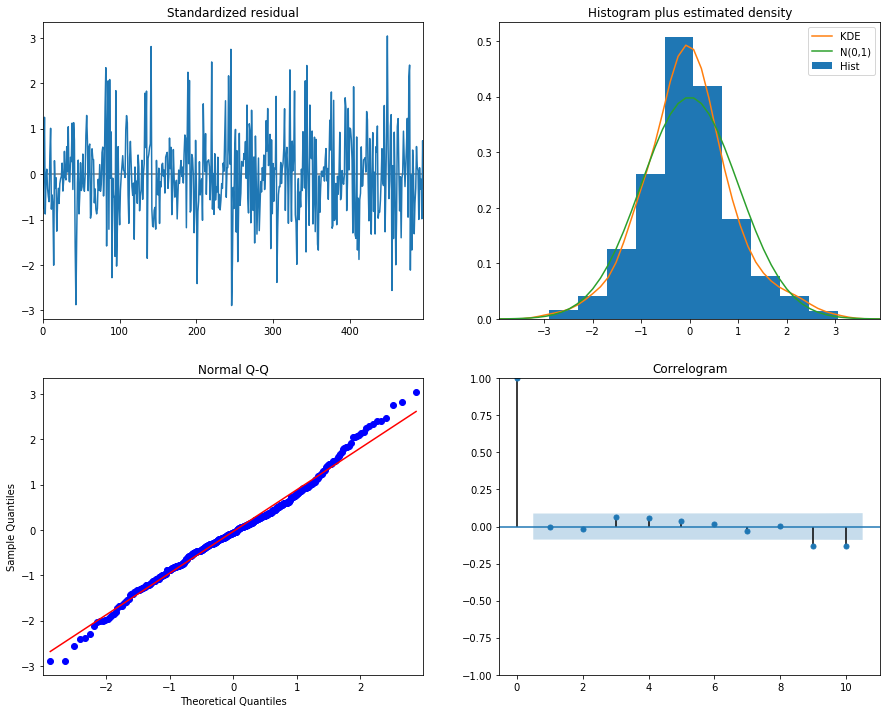

In [65]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    
- задаем длину сезона (52 - полный сезон или  26 недель - зимой греем, летом кондиционируем и расход энергии примерно одинаковый)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [27]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 0, 52)
SARIMAX: (0, 0, 2) x (0, 0, 0, 52)
SARIMAX: (0, 0, 2) x (0, 0, 1, 52)


In [28]:
data_w['PJME_MW'].values.shape

(866,)

Проведем исследование параметров в диапазонах "разумного" изменения параметров модели:

In [ ]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[300:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)3 - AIC:12624.295159952431
ARIMA(0, 0, 0)x(0, 0, 1, 52)3 - AIC:11068.373238340097
ARIMA(0, 0, 0)x(0, 0, 2, 52)3 - AIC:9806.343406680917
ARIMA(0, 0, 0)x(0, 1, 0, 52)3 - AIC:9100.734066398636
ARIMA(0, 0, 0)x(0, 1, 1, 52)3 - AIC:8077.802988201593
ARIMA(0, 0, 0)x(0, 1, 2, 52)3 - AIC:7071.153104646539
ARIMA(0, 0, 1)x(0, 0, 0, 52)3 - AIC:12222.359403009534
ARIMA(0, 0, 1)x(0, 0, 1, 52)3 - AIC:10949.34618085106
ARIMA(0, 0, 1)x(0, 0, 2, 52)3 - AIC:9753.54521133068
ARIMA(0, 0, 1)x(0, 1, 0, 52)3 - AIC:9024.342528152685
ARIMA(0, 0, 1)x(0, 1, 1, 52)3 - AIC:8008.24288656387
ARIMA(0, 0, 1)x(0, 1, 2, 52)3 - AIC:6992.181248857538
ARIMA(0, 0, 2)x(0, 0, 0, 52)3 - AIC:12107.39430953267
ARIMA(0, 0, 2)x(0, 0, 1, 52)3 - AIC:10901.714595938087
ARIMA(0, 0, 2)x(0, 0, 2, 52)3 - AIC:9719.451018632986
ARIMA(0, 0, 2)x(0, 1, 0, 52)3 - AIC:8997.733061900464
ARIMA(0, 0, 2)x(0, 1, 1, 52)3 - AIC:7977.06399278545
ARIMA(0, 0, 2)x(0, 1, 2, 52)3 - AIC:6962.031401472654
ARIMA(0, 1, 0)x(0, 0, 0, 52

Лучшие результаты на недельных данных параметры модели SARIMA(1,1, 2)x(0, 1, 2, 52) - AIC:6867.79 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

In [66]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 =300   # берем дданные не от начала - так быстрее работает
N2=12  # число точек для теста
nforecast = N2+30

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[N1:-N2],order=[1,1,2],
                                seasonal_order=[0,1,2,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 7236.79456492689


Проведем моделирование прогноза на основе найденой SARIMAX[1, 1, 2]x[0, 1, 2, 52]  и модели  SARIMA(1, 2, 2)x(0, 0, 1, 52) для последних 12 дней(и предсказание следующих 30 )  и сравним их с фактом.

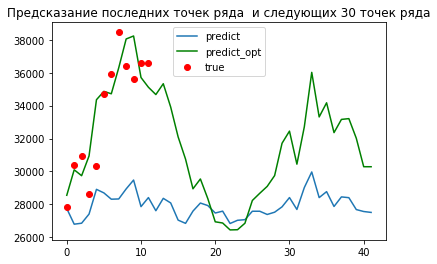

In [67]:
nforecast = N2+30  # полное число предиктов (тест+ чистый предикт)

pred_dynamic = results.forecast(nforecast)    #делаем предсказание на 30 точtк от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(nforecast)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [32]:
results_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6811,0.139,4.902,0.000,0.409,0.953
ma.L1,-1.3205,0.182,-7.260,0.000,-1.677,-0.964
ma.L2,0.3253,0.169,1.923,0.055,-0.006,0.657
ma.S.L52,-0.7320,0.075,-9.798,0.000,-0.878,-0.586
ma.S.L104,-0.0299,0.069,-0.432,0.666,-0.165,0.106
sigma2,7.893e+06,2.91e-08,2.71e+14,0.000,7.89e+06,7.89e+06


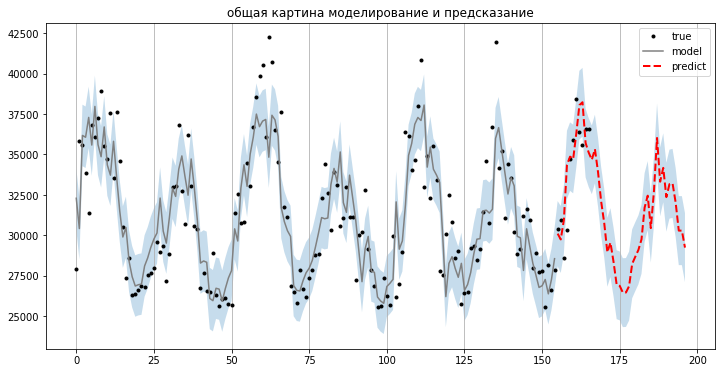

In [33]:
N3=400  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+30  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_w['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

Видно, что предсказание новых точек тем слабее, чем дальше от последней известной точки ряда. Это можно объяснить тем, что накапливается ошибка предсказания или изменились условия развития ряда (наш котенок перестанет когда-нибудь расти и следовательно его скорость и маневренность долгое время не будут изменяться). Кроме того, модель, которую выбрали по сетке, заметно лучше обходит точки известные нам заранее и имеет более сложный характер. Таким образом, подбор позволил улучшить исходный результат для ряда с сезонами и циклами. 

Повторим процесс для второго ряда "Цена нефти Brent" и посмотрим на особенности моделирования такого ряда. Напомним, что нет сезонности, есть интегральность, есть изменяющиеся во времени тенденции (временные ряды 2).

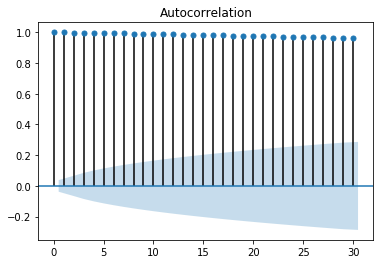

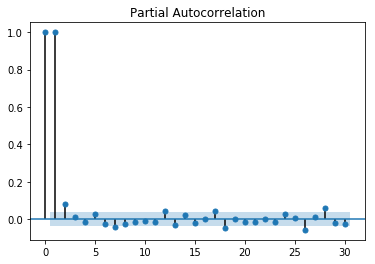

In [34]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(brent_data['Значение'].values, lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data['Значение'].values, lags=30)
plt.show()

Построим ACF и PACF для первых разностей

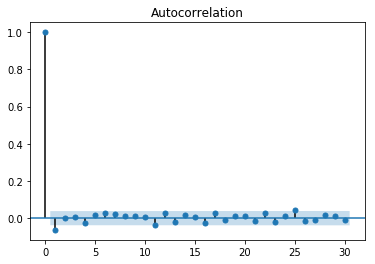

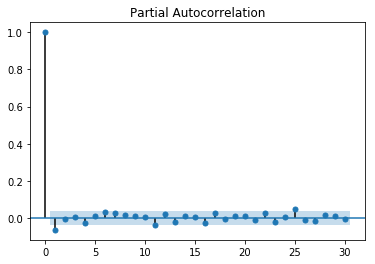

In [35]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
brent_dif = brent_data['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif[1:], lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_dif[1:], lags=30)
plt.show()

Дневные графики показывают автокорреляцию цены со всеми значениями ранее (это не очень хорошо) и для на PACF мы видим, что только 1-й порядок разностей важен для нашего процесса (AR 1). Это полностью согласуется с проведенным ранее анализом. Таким образом:
 - Сезона нет.
 - ACF - медленно падает для дневныхи графиков, а для первых разностей ACF - быстро падает (не более 1-й корреляции)  
 - PACF - быстро пададает,  а для первых разностей РACF - быстро падает (не более 1-й корреляции) 
 - q , p - берем р=1(2) (PACF) , q =1(2) (скорее всего не очень большой после производной)
 - ADF - 1 раз интегрируемый - d = 1 

Запустим модель без сезонного анализа (ARIMA)


In [36]:
# Определим p, d и q 
q = 1
p = 2
d = 1
pdq = [p, d, q]

N2=30
warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(brent_data['Значение'].values[:-N2],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[2, 1, 1] - AIC:8588.988630267817
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2637
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -4288.494
Date:                Fri, 31 Jul 2020   AIC                           8588.989
Time:                        18:44:13   BIC                           8624.246
Sample:                             0   HQIC                          8601.755
                               - 2637                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    

Коэффициент модели  ar.L2 имеет малое абсолютное значение, что свидетельствует о том, что он не играет роли при определении ответа модели. посмотрим на визуализацию результатов работы модели, где видно, что остатки ряда распределены не одинаково на краях модели и в ее основной части, что не позволит принимать правильное решение (рис.Normal Q-Q, Standardized rezidual)

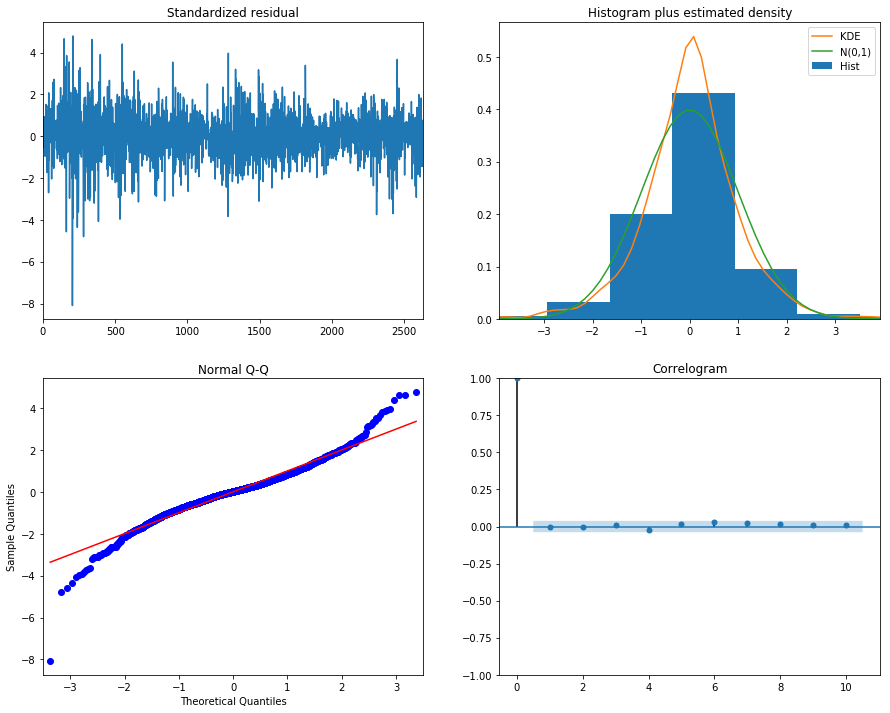

In [37]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

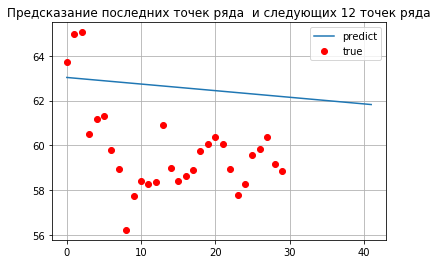

In [38]:
pred_dynamic = resultsb.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-30:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()
plt.grid()
plt.plot()
plt.show()

Для подбора оптимальных значений параметров модели временного ряда ARIMA (p, d, q), используем сеточный поиск

In [ ]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0, 7)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(brent_data['Значение'].values[:-100]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

 Поиск по сетке определяет модель ARIMA(1, 1, 0)- AIC:-13993.81

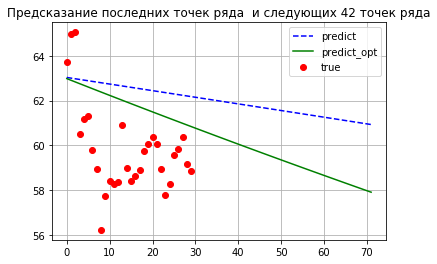

In [39]:

N2=30
nforecast = N2+42

modb_opt = sm.tsa.statespace.SARIMAX(brent_data['Значение'].values[:-N2],
                               order=[1,0,1],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(nforecast)    #делаем предсказание c 30 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(72) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.legend()
plt.grid()
plt.show()

Улучшеная модель ближе к первым по времени точкам выборки на отрезке предсказания. Однако общий результат моделирования еще далек от идеала. Проверим остатки модели.

In [40]:
resultsb_opt.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.3562,0.160,2.224,0.026,0.042,0.670
drift,-9.469e-05,4.6e-05,-2.060,0.039,-0.000,-4.6e-06
ar.L1,0.9971,0.001,740.257,0.000,0.994,1.000
ma.L1,-0.0623,0.016,-3.897,0.000,-0.094,-0.031
sigma2,1.5170,0.025,60.334,0.000,1.468,1.566


Посмотрим на модель на этапе предсказания и этапе описания данных

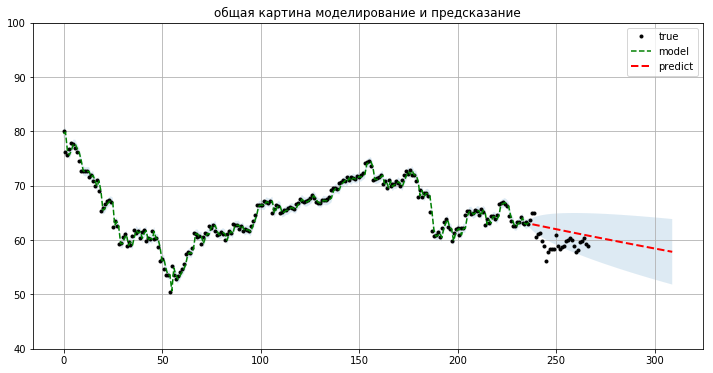

In [41]:
N2=30 # число точек для теста
nforecast = N2+42  # общее число точек для предсказания (тест+ чистое предсказание)
N3=2400  # отступ от начала известной информации для визуализации - так виднее (можно брать 0-2600)
predict_ = resultsb_opt.get_prediction(end=resultsb_opt.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_data['Значение'].values[N3:], 'k.',label='true')
plt.ylim([40,100])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

In [42]:

adf_test = sm.tsa.stattools.adfuller(resultsb_opt.resid)
print(adf_test)


(-80.24885030948923, 0.0, 0, 2636, {'1%': -3.4328331864239274, '5%': -2.8626370834536976, '10%': -2.56735401579277}, 8506.238580534135)


ADF тест (adf_test[1] = 0) показывает, что пока остатки являются стационарным рядом,и хотя модель требует доработки, она отвечает на вопрос о поведении ряда во времени. Это значит, что можно уверенно прогнозировать - значения модели в диапазоне дисперсии остатков.  

Посмотрим на модель для 1-х разностей.

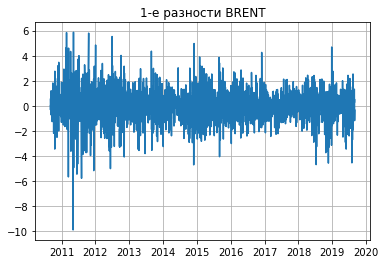

In [43]:
plt.plot(brent_dif)
plt.grid()
plt.title('1-е разности BRENT')
plt.show()

In [44]:


import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(0,1)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_bd = sm.tsa.statespace.SARIMAX(brent_dif[100:-100],order=param,seasonal_order=[0,0,0,0],
                                          stepwise=False, approximation=False, max_order=2)

        results_ = mod_bd.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:8071.704148175584
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:9926.5639363134
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:8064.22003396567
ARIMA(1, 1, 0)x[0, 0, 0, 0] - AIC:9119.372696938808


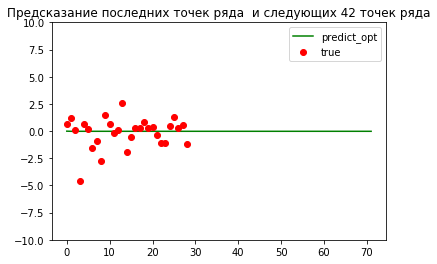

In [45]:
N1=100
N2=30
nforecast = N2+42
modb_optd = sm.tsa.statespace.SARIMAX(brent_dif[N1:-N2],
                               order=[1,0,0],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_optd = modb_optd.fit()
#делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_optd.forecast(nforecast) 

plt.plot(pred_dynamic_opt.values,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_dif.values[-N2:-1],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.ylim([-10,10])
plt.legend()
plt.plot()
plt.show()

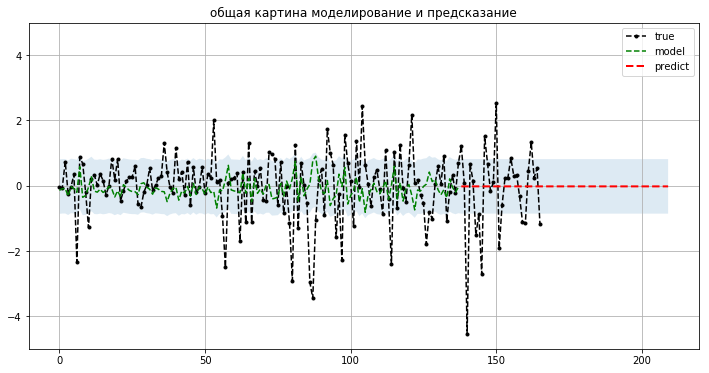

In [46]:
N3 = 2400
predict_ = resultsb_optd.get_prediction(end=resultsb_optd.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_dif.values[N3+N1:-1], '--k.',label='true')
plt.ylim([-5,5])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast]*5, '--g',label='model') # увеличена амплитуда в 5 раз - иначе не видно
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci.iloc[N3:, 0], predict_ci.iloc[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

Модель "Идеальна" , т.к. это случайное биение, которое ARIMA предсказывает очень хорошо (описываем параметры шума).

## Сохраниение модели

In [ ]:
resultsb_opt.save('rez_model.h5') # и обратно t_rez = sm.load('rez_model.h5')

## Выводы

1. Модель ARIMA строить линейное описание, но берет сложные входные признаки

2. Для анализа параметров ARIMA используем ACF, PACF

3. Моделей хороших много 

4. Поиск модели проводим через перебор нескольких в разумном диапазоне параметров

5. Выбираем ту, что "хорошая" и маленькая

6. Модель имеет ограничения (применима не всегда)



# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4. Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )


5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.